### Contents of this notebook:
* A CNN model that performs binary classification.
* It classifies images into two classes - "Teeth"/"Non-teeth".

In [1]:
# Necessary imports
import torch
from torch import nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary

In [2]:
# Device agnostic code.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Current device: {device}")

Current device: cuda


In [3]:
# Total number of images in the `images_random` directory
import os
from pathlib import Path

rimg_path = Path('images_random')
n_imgs = len(os.listdir(rimg_path))
print(f"Total number of images: {n_imgs}")

Total number of images: 2047


#### A script to to create a custom dataset.
* There's a script in this project folder named `data_split2.py` that has been used for performing the train and test split.
* The `teeth` folder contains the teeth images.
* The `not_teeth` folder contains the no-teeth images.

And now that the data has been created, setting up some paths.

In [4]:
# Setting some paths for the custom dataset.

root_dir = Path("teeth_validate")
train_dir = root_dir / "train"
test_dir = root_dir / "test"

print(f"Root directory: {root_dir}")
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Root directory: teeth_validate
Train directory: teeth_validate\train
Test directory: teeth_validate\test


#### Visualizing some images from the custom dataset.

In [5]:
# This function is from notebook-1
# The teeth images are in jpeg format and the non teeth images are in jpg format

import PIL
import random
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

def show_random_images(path:pathlib.Path, img_type:str):
    """Shows random images from the train or test directory.
    Args:
        path: pathlib.Path object.
    Returns:
        It returns a matplotlib figure objects with three subplots, random images from the particular directory.
        plt.figure() object."""
    

    plt.figure(figsize=(12,8))
    img_path_list = list(path.glob(f'*/*.{img_type}'))
    for i in range(3):
        rand_index = random.randint(0, len(img_path_list)-1)
        random_path = img_path_list[rand_index]
        rand_pil_img = PIL.Image.open(random_path)
        img_array = np.asarray(rand_pil_img)

        plt.subplot(1, 3, i+1)
        plt.imshow(img_array)
        plt.axis(False)
        # Last part of the parent direcotry path as the title.
        plt.title(random_path.parent.stem)

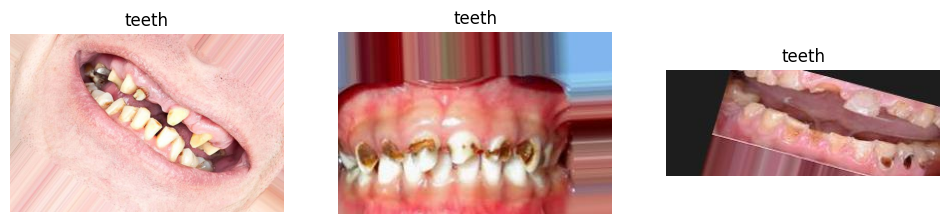

In [6]:
show_random_images(train_dir, "jpeg")

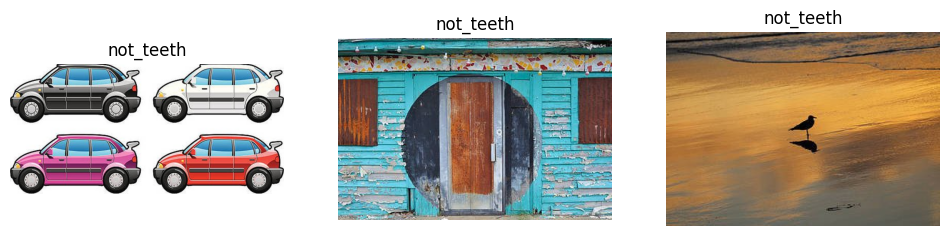

In [7]:
show_random_images(train_dir, "jpg")

#### Class names.

In [8]:
class_names = os.listdir(train_dir)
class_names

['not_teeth', 'teeth']

#### Trying out the tinyvgg model architecture from the CNN explainer website.

In [9]:
from torchscript import model_builder

In [10]:
torch.manual_seed(42)
model_vgg = model_builder.TinyVGG(
    input_shape=3, # RGB = 3
    hidden_units=15,
    output_shape=1
).to(device=device)

print(f"Model description of the tiny vgg model:\n{model_vgg}")

Model description of the tiny vgg model:
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2535, out_features=1, bias=True)
  )
)


#### Creating dataloaders for the model.

In [11]:
# Image transformations pipeline for the tiny vgg model
transform_vgg = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

transform_vgg

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [12]:
train_data = ImageFolder(
    root=train_dir,
    target_transform=None,
    transform=transform_vgg
)

test_data = ImageFolder(
    root=test_dir,
    target_transform=None,
    transform=transform_vgg
)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0, # Everything on the main thread
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)

class_names = train_data.classes
# Check all the instances
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x24ae717e240>,
 ['not_teeth', 'teeth'])

In [13]:
# Get the first batch of the dataloader.
X, y = next(iter(train_dataloader))
print(f"Shape of first batch: {X.shape}")
print(f"Labels of first batch: {y}")

Shape of first batch: torch.Size([32, 3, 64, 64])
Labels of first batch: tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0])


In [14]:
# Trying a dummy pass through the model.
# Converting the raw logits into pred probs.
# And then the pred probs into labels.
model_vgg(torch.randn(size=(1, 3, 64, 64)).to(device=device))

tensor([[0.0470]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
y.shape

torch.Size([32])

In [16]:
from tqdm import tqdm
from timeit import default_timer as time_stamp
import torch
import torch.nn as nn
from helper_functions import accuracy_fn

# Training part
optimizer = torch.optim.Adam(params=model_vgg.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()  # This has sigmoid function built in!

# Number of epochs
epochs = 10

start_time = time_stamp()
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in tqdm(range(epochs)):
    train_acc = 0
    train_loss = 0
    
    model_vgg.train()  # Set model to training mode
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        logits = model_vgg(X).squeeze()  # Ensure the output shape is [batch_size]
        y_preds = torch.round(torch.sigmoid(logits))  # Get predictions

        # Calculate loss
        loss = loss_fn(logits, y.type(torch.float32))  # Ensure y is float32
        acc = accuracy_fn(y_pred=y_preds, y_true=y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += acc
        train_loss += loss.item()  # Accumulate loss as a scalar

    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)

    model_vgg.eval()  # Set model to evaluation mode
    with torch.inference_mode():
        test_acc = 0
        test_loss = 0
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass for test data
            logits_test = model_vgg(X).squeeze()
            y_preds_test = torch.round(torch.sigmoid(logits_test))  # Get predictions
            loss_test = loss_fn(logits_test, y.type(torch.float32))  # Calculate test loss
            acc_test = accuracy_fn(y_pred=y_preds_test, y_true=y)

            test_acc += acc_test
            test_loss += loss_test.item()  # Accumulate test loss

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Epoch-{epoch + 1}:")
    print(f"Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f} | Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


 10%|█         | 1/10 [00:03<00:32,  3.65s/it]

Epoch-1:
Train loss: 0.4669, Test loss: 0.2567 | Train acc: 75.8750, Test acc: 89.6635


 20%|██        | 2/10 [00:05<00:22,  2.78s/it]

Epoch-2:
Train loss: 0.1720, Test loss: 0.1660 | Train acc: 93.3750, Test acc: 93.9904


 30%|███       | 3/10 [00:08<00:17,  2.52s/it]

Epoch-3:
Train loss: 0.1751, Test loss: 0.1573 | Train acc: 93.3750, Test acc: 94.7115


 40%|████      | 4/10 [00:10<00:14,  2.40s/it]

Epoch-4:
Train loss: 0.1292, Test loss: 0.1436 | Train acc: 94.6875, Test acc: 95.4327


 50%|█████     | 5/10 [00:12<00:11,  2.39s/it]

Epoch-5:
Train loss: 0.1396, Test loss: 0.1430 | Train acc: 94.8125, Test acc: 93.9904


 60%|██████    | 6/10 [00:14<00:09,  2.38s/it]

Epoch-6:
Train loss: 0.1258, Test loss: 0.1964 | Train acc: 94.5000, Test acc: 91.8269


 70%|███████   | 7/10 [00:17<00:07,  2.46s/it]

Epoch-7:
Train loss: 0.1040, Test loss: 0.1237 | Train acc: 96.2500, Test acc: 95.1923


 80%|████████  | 8/10 [00:20<00:05,  2.71s/it]

Epoch-8:
Train loss: 0.1091, Test loss: 0.1117 | Train acc: 96.1875, Test acc: 95.9135


 90%|█████████ | 9/10 [00:23<00:02,  2.60s/it]

Epoch-9:
Train loss: 0.1056, Test loss: 0.1112 | Train acc: 96.0000, Test acc: 95.9135


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

Epoch-10:
Train loss: 0.1071, Test loss: 0.1293 | Train acc: 96.0625, Test acc: 95.6731


#### Saving the model.

In [17]:
vgg_model_path = Path('models/vgg_binary.pth')
torch.save(obj=model_vgg.state_dict(), f=vgg_model_path)
print(f"Model has been saved!")

Model has been saved!


In [18]:
loaded_model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=15,
    output_shape=1
).to(device=device)

loaded_state_dict = torch.load(f=vgg_model_path, weights_only=True)
loaded_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

#### Checking the accuracy of the loaded model.

In [19]:
loaded_model.eval()  # Set model to evaluation mode
with torch.inference_mode():
    test_acc = 0
    test_loss = 0
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass for test data
        logits_test = loaded_model(X).squeeze()
        y_preds_test = torch.round(torch.sigmoid(logits_test))  # Get predictions
        loss_test = loss_fn(logits_test, y.type(torch.float32))  # Calculate test loss
        acc_test = accuracy_fn(y_pred=y_preds_test, y_true=y)

        test_acc += acc_test
        test_loss += loss_test.item()  # Accumulate test loss

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Loss: {test_loss}")
print(f"Accuracy: {test_acc}")

100%|██████████| 13/13 [00:00<00:00, 30.95it/s]

Loss: 0.11276124962247334
Accuracy: 95.91346153846153


#### Creating a function to do predictions and plot them as well.
* This function will use the dataloader to do the predictions.
* It will use the test dataloader because that is unseen set of data.

In [20]:
from PIL import Image
transform_vgg(Image.open('teeth_validate/train/not_teeth/15.jpg')).shape

torch.Size([3, 64, 64])

In [21]:
X[0].shape

torch.Size([3, 64, 64])

In [22]:
from torch.utils.data import DataLoader
from typing import List
import matplotlib.pyplot as plt

def predict_plot_vgg(model:torch.nn.Module, dataloader:DataLoader, device:torch.device=device, class_names:List[str]=class_names):
    """This function predicts and plots. It uses the test dataloader that is the unseen set of data, that the model has never seen."""

    plt.figure(figsize=(7, 7))
    X, y = next(iter(dataloader))
    X, y = X.to(device), y.to(device)

    # print(f"Shape of X: {X.shape}")
    # print(f"Shape of y: {y.shape}")

    model.eval()
    with torch.inference_mode():
        for i in range(9):
            ind = random.randint(0, len(X)-1)

            img_tensor = X[ind]
            logits = model(img_tensor.unsqueeze(dim=0))

            pred_prob = torch.sigmoid(logits).item()
            pred_prob = round(pred_prob, 2)
            pred_label = torch.round(torch.sigmoid(logits)).type(torch.int32).item()

            plt.subplot(3, 3, i+1)
            plt.axis(False)
            plt.imshow(img_tensor.cpu().permute(1, 2, 0))
            if pred_label == y[ind]:
                plt.title(f"Label: {class_names[pred_label]}\nPred-prob: {pred_prob}", color='green')
            else:
                plt.title(f"Label: {class_names[pred_label]}\nPred-prob: {pred_prob}", color='red')

            plt.subplots_adjust(wspace=0.55, hspace=0.6)


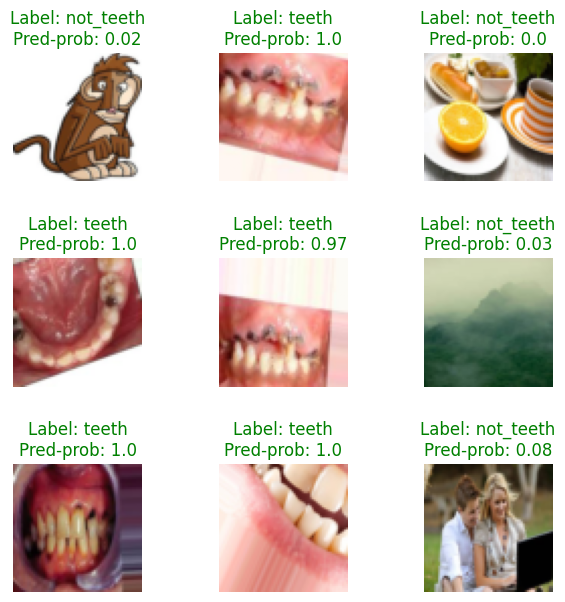

In [23]:
predict_plot_vgg(model=loaded_model, dataloader=test_dataloader,
                 device=device, class_names=class_names)